# <img src="assets/ufscar.png" alt="Logo UFScar" width="200" align="left"/><p><center>Universidade Federal de São Carlos (UFSCar)</center><br/><font size="4"><center> Departamento de Computação, campus Sorocaba </center> </font>


<font size="4"><center><b>Disciplina: Aprendizado de Máquina</b></center></font>
<font size="3"><center>Prof. Dr. Tiago A. Almeida</center></font>
</p>

<br>
<font size = "4"><center><b> Grupo 5: Análise de sentimento de reviews na Amazon </b></center></font>
<br>

# Naive Bayes Classifier

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pre_processing as pp
import analysis as anl
import pca

# Categoria da base de dados a ser lida (do disco) e processada
# [books, kitchen_&_housewares, electronics, dvd, all]
category = 'test'

# Se positivo, adiciona bigramas para reviews negativas
# ex: ('not', 'good') equivale a uma única feature
hNeg = True

# Se positivo, adiciona substantivos
noun = False

# Guarda as features já pré processadas em X, a classe da amostra em Y e o vocabulário em vocabulary
# hNeg e noun são opcionais, por padrão hNeg=True, noun=False
X, Y, vocabulary = pp.bow(category, hNeg, noun)

print("Vocabulário possui " + str(len(vocabulary)) + " palavras!")

Vocabulário possui 1509 palavras!


#### Separa os dados em treinamento e teste:

In [2]:
# semente usada na randomizacao dos dados.
randomSeed = 10 

# gera os indices aleatorios que irao definir a ordem dos dados
idx_perm = np.random.RandomState(randomSeed).permutation(range(len(Y)))

# ordena os dados de acordo com os indices gerados aleatoriamente
X2, Y2 = X[idx_perm, :], Y[idx_perm]

# Porcentagem de amostras destinadas à base de treino
pTrain = 0.8

# Executa o holdout e retorna os índices de treino e teste, mantendo a proporção original entre as classes
train_index, test_index = anl.stratified_holdOut(Y, pTrain)

# Guarda as amostras de treino e teste
Xtrain, Xval = X2[train_index, :], X2[test_index, :]
Ytrain, Yval = Y2[train_index], Y2[test_index]

#### Seleciona features com chi-quadrado (a partir dos dados de treinamento):

In [3]:
# Seta o valor de alpha para o chi-quadrado. 
# alpha é opcional, por padrão alpha = 0.05
alpha = 0.05

# Chama a função para executar o chi-quadrado e retorna a nova base de dados reduzida
# o novo vocabulário e os índices das features mantidas
Xtrain, new_vocabulary, index = pp.chi2(Xtrain, Ytrain, vocabulary, alpha)

# Seleciona apenas as features do índice retornado pelo chi-quadrado para a base de teste
Xval = Xval[:, index]

In [4]:
print("Número de features antes do chi-quadrado: " + str(len(vocabulary)))
print("----------------------------------------")
print("Número de features após chi-quadrado: " + str(len(new_vocabulary)))
print(new_vocabulary)

Número de features antes do chi-quadrado: 1509
----------------------------------------
Número de features após chi-quadrado: 26
['love', 'paleolith', 'written', 'well', 'explain', 'not', 'good', 'heal', 'pain', 'true', 'mean', 'wish', 'tri', 'said', 'whole', 'bad', 'less', 'wast', 'wild', 'entir', 'eat', 'hormon', 'die', 'horribl', 'legal', 'arab']


#### Função auxiliar para calcular a probabilidade de ocorrência de cada feature em cada classe:

In [5]:
def calcularProbabilidades(X, Y):
   
    # Inicializa as variáveis de retorno, que guardarão a probabilidade das features ocorrerem em 
    # cada classe
    pPos = np.zeros(X.shape[1])
    pNeg = np.zeros(X.shape[1])

    # Calcula a probabilidade de ocorrência de cada feature de cada amostra por classe
    # e guarda nas variáveis de retorno
    pPos = (X[(Y == 1)].sum(axis=0) + 1)/(sum(Y == 1) + X.shape[1])
    pNeg = (X[(Y == 0)].sum(axis=0) + 1)/(sum(Y == 0) + X.shape[1])
    
    # Probabilidade de ocorrência de cada classe
    probPos = sum(Y==1)/len(Y) 
    probNeg = sum(Y==0)/len(Y)
    
    return probPos, probNeg, pPos, pNeg

In [6]:
# Chama a função e guarda as probabilidades
probP, probN, pPos, pNeg = calcularProbabilidades(Xtrain, Ytrain)

#### Implementação da classificação do Naive Bayes:

In [7]:
def classificacao(x, probP, probN, pPos, pNeg):
    # Inicializa variáveis auxiliares e de retorno
    classe = 0;
    probPos= 0;
    probNeg = 0;

    # Converte x de matriz sparsa para um array
    x = x.toarray()
    
    # Calcula os produtórios das probabilidades de cada feature por classe 
    # multiplicado pela probabilidade de cada classe
    probPos = probP * (pPos[(x != 0)]).prod() * (1 - pPos[(x == 0)]).prod()
    probNeg = probN * (pNeg[(x != 0)]).prod() * (1 - pNeg[(x == 0)]).prod()
    
    # Retorna a classe com maior probabilidade
    classe = int(probPos >= probNeg)

    return classe

#### Função auxiliar para predizer um conjunto de amostras:

In [8]:
# Dadas as probabilidades, faz a predição de um conjunto de amostras
def predicao(Xval, Yval, probP, probN, pPos, pNeg):
    
    # Inicializa a variável de retorno, com as predições para cada amostra    
    Ypred = []
    
    # Executa o classificador naive bayes para cada amostra e guarda em Ypred
    for i in range(Xval.shape[0]):
        y = classificacao(Xval[i], probP,probN,pPos,pNeg)
        Ypred.append(y)

    # Calcula a acurácia da predição para o conjunto Xval
    acuracia = np.sum(Ypred==Yval)/len(Yval)
    
    return Ypred, acuracia

#### Predição da base de teste do Holdout:

In [9]:
Ypred, acuracia = predicao(Xval, Yval, probP, probN, pPos, pNeg)
print("Acurácia é " + str(acuracia*100))

# Guarda a quantidade de classes da base
classes = np.unique(Y)

auxResults = anl.relatorioDesempenho(Yval, Ypred, classes, imprimeRelatorio=True)

Acurácia é 81.25

	Revocacao   Precisao   F-medida   Classe
	0.750       0.857      0.800      0
	0.875       0.778      0.824      1
	------------------------------------------------
	0.812       0.817      0.815      Média macro
	0.812       0.812      0.812      Média micro

	Acuracia: 0.812


## Curva de Aprendizado: 

In [10]:
def curva_aprendizado(X, Y, Xval, Yval, num_iteracoes = 0):
   
    """
    Funcao usada gerar a curva de aprendizado.
  
    Parametros
    ----------
  
    X : matriz com os dados de treinamento
  
    Y : vetor com as classes dos dados de treinamento
  
    Xval : matriz com os dados de validação
  
    Yval : vetor com as classes dos dados de validação
    
    num_iteracoes : escalar indicando a quantidade de iterações
  
    """

    # Define a quantidade de iteracoes, por padrão, itera por cada amostra da base de treino
    if (num_iteracoes <= 0 or num_iteracoes > len (Y)):
        num_iteracoes = len (Y)    
    
    # inicializa as listas que guardarao a performance no treinamento e na validacao
    perf_train = []
    perf_val = []

    # Guarda a quantidade de classes da base
    classes = np.unique(Y)
    
    
    # Itera e executa o classificador naive bayes com i amostras da base de treino para cada iteracao
    for i in range(10, len(Y), int (len(Y)/num_iteracoes)):
        
        probP, probN, pPos, pNeg = calcularProbabilidades(X[:i], Y[:i])
        
        Ypred, acuracia = predicao(X[:i], Y[:i], probP, probN, pPos, pNeg)
        
        # Guarda a acuracia da iteracao usando a base de treino como teste
        perf_train.append(acuracia)

        Ypred, acuracia = predicao(Xval, Yval, probP, probN, pPos, pNeg)
        
        # Guarda a acuracia da iteracao usando a base de validacao como teste
        perf_val.append(acuracia)


    ##################################################################################
       
    # Define o tamanho da figura 
    plt.figure(figsize=(20,12))

    # Plota os dados
    plt.plot(perf_train, color='blue', linestyle='-', linewidth=1.5, label='Treino') 
    plt.plot(perf_val, color='red', linestyle='-', linewidth=1.5, label='Validação')

    # Define os nomes do eixo x e do eixo y
    plt.xlabel(r'# Qtd. de dados de treinamento',fontsize='x-large') 
    plt.ylabel(r'Acuracia',fontsize='x-large') 

    # Define o título do gráfico
    plt.title(r'Curva de aprendizado', fontsize='x-large')

    # Acrescenta um grid no gráfico
    plt.grid(axis='both')

    # Plota a legenda
    plt.legend()
    
    plt.show()

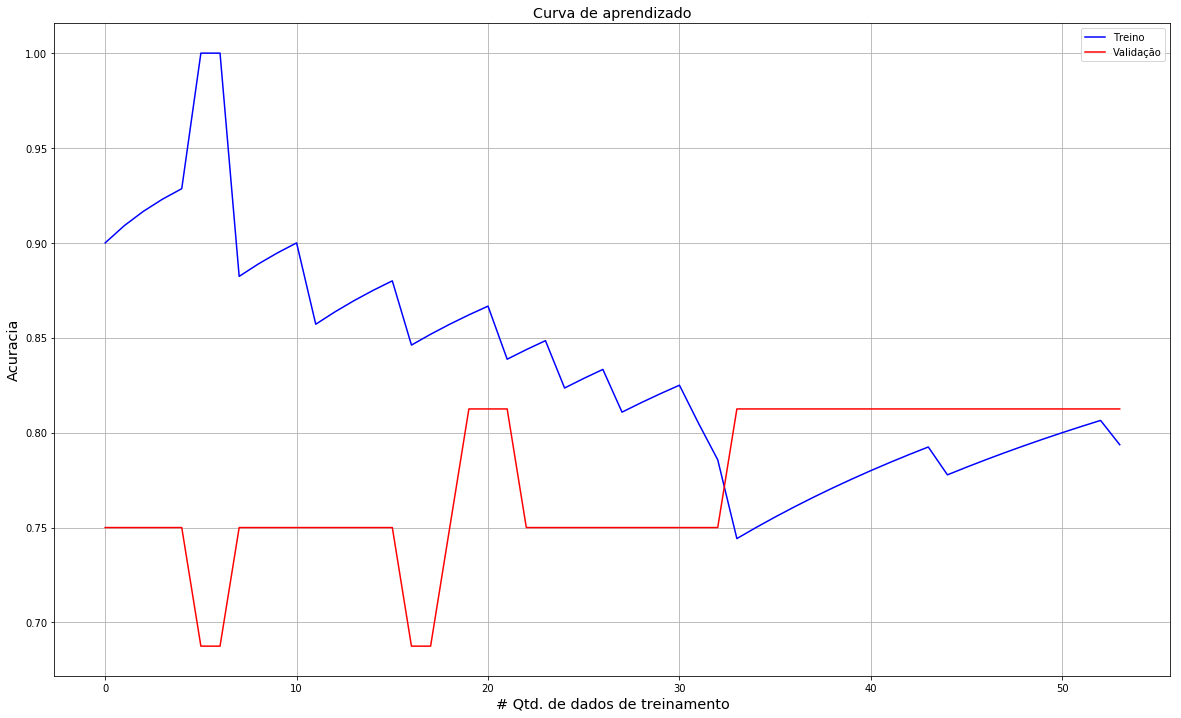

In [11]:
# num_iteracoes = numero de iterações da curva de aprendizado, por padrao e igual ao numero de amostras da base
curva_aprendizado(Xtrain, Ytrain, Xval, Yval, num_iteracoes = 100)

## K-Folds

In [12]:
import k_folds as kf

# Guarda todos os tipos de classes 
classes = np.unique(Y)

# Quantidade de Folds a ser executado
nFolds = 5

# Guarda os índices dos nFolds
fold = kf.stratified_kfolds(Y, nFolds, classes)

# Cria uma lista vazia para guardar os resultados obtidos em cada fold
resultados = []

# Apenas para controle das iteracoes
k = 1

for train_index, test_index  in fold :
    
    print('\n-----------\n%d-fold: \n-----------\n' % (k) )
    
    # Guarda as bases de treino e teste baseado nos índices de cada fold
    Xtrain, Xval = X2[train_index,:], X2[test_index, :]
    Ytrain, Yval = Y2[train_index], Y2[test_index]
    
    # Executa o chi-quadrado na base do fold atual
    Xtrain, new_vocabulary, index = pp.chi2(Xtrain, Ytrain, vocabulary)
    Xval = Xval[:, index]
    
    # Execucao do Classificador Naive Bayes
    probP, probN, pPos, pNeg = calcularProbabilidades(Xtrain, Ytrain)
    result, acuracia = predicao(Xval, Yval, probP, probN, pPos, pNeg)

    # Relatorio do fold
    auxResults = anl.relatorioDesempenho(Yval,result, classes, imprimeRelatorio=True)
    resultados.append( auxResults )
    
    # Incremento da variavel de controle
    k += 1
    
kf.mediaFolds(resultados, classes)  


-----------
1-fold: 
-----------


	Revocacao   Precisao   F-medida   Classe
	0.857       0.750      0.800      0
	0.800       0.889      0.842      1
	------------------------------------------------
	0.829       0.819      0.824      Média macro
	0.824       0.824      0.824      Média micro

	Acuracia: 0.824

-----------
2-fold: 
-----------


	Revocacao   Precisao   F-medida   Classe
	0.750       0.545      0.632      0
	0.375       0.600      0.462      1
	------------------------------------------------
	0.562       0.573      0.568      Média macro
	0.562       0.562      0.562      Média micro

	Acuracia: 0.562

-----------
3-fold: 
-----------


	Revocacao   Precisao   F-medida   Classe
	0.400       1.000      0.571      0
	1.000       0.500      0.667      1
	------------------------------------------------
	0.700       0.750      0.724      Média macro
	0.625       0.625      0.625      Média micro

	Acuracia: 0.625

-----------
4-fold: 
-----------


	Revocacao   Precisao 